In [1]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
plt.style.use('ggplot')
data = pd.read_csv('bg_master_1.csv')
# data.head(10)
# data.columns


In [2]:
# data.hist(figsize=(18,10) );
data['ENTRIES'][321] = (data.iloc[320].ENTRIES + data.iloc[322].ENTRIES) // 2
data['ENTRIES'][173] = (data.iloc[172].ENTRIES + data.iloc[174].ENTRIES) // 2
data['ENTRIES'][180] = (data.iloc[179].ENTRIES + data.iloc[181].ENTRIES) // 2
data['ENTRIES'][211] = (data.iloc[204].ENTRIES + data.iloc[218].ENTRIES) // 2 # Saturday
data['ENTRIES'][212] = (data.iloc[205].ENTRIES + data.iloc[219].ENTRIES) // 2
data['ENTRIES'][323] = (data['ENTRIES'][316] + data['ENTRIES'][330])// 2#data.loc[316].ENTRIES # Saturday
data['ENTRIES'][324] = (data['ENTRIES'][317] + data['ENTRIES'][331]) // 2
# consider refactoring to use .loc to avoid warnings 
# consider generalizing into helper function "turnstile_clean()"

def is_weekend(date):
    if date.weekday() >= 5:
        return 1
    else: 
        return 0 
    
data['DATE2'] = pd.to_datetime(data.DATE2)
data['is_weekend'] = data.apply(lambda r: is_weekend(r.DATE2), axis=1)
wkend_entries = data[data.is_weekend == 1]
weekday_entries = data[data.is_weekend == 0]
features = ['PRCP','SNOW','SNWD','TMAX','TMIN']

/Users/christophermanna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/christophermanna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/christophermanna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after remo

In [3]:
def feature_plots_with_graphs(df):
    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ]]
    for feature in features: 
        f = 'ENTRIES~' + feature
        print('\n', "Subway Weekend - Regression Analysis and Diagnostics for formula: ",f)
        print("--------------------------------------------------------------------------------------")
        model = ols(formula=f, data=df).fit()
        df_min_max = pd.DataFrame({feature: [df[feature].min(), df[feature].max()]})
        preds = model.predict(df_min_max)
        df.plot(kind='scatter', x=feature, y='ENTRIES')
        plt.plot(df_min_max, preds, c='red', linewidth=2)
        plt.show()
        fig = plt.figure(figsize=(15,8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True,   )
        plt.show()
        results.append([feature, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0] ])    
    return results

def feature_results_summary(df):
    results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ]]
    for feature in features: 
        f = 'ENTRIES~' + feature
        model = ols(formula=f, data=df).fit()
        df_min_max = pd.DataFrame({feature: [df[feature].min(), df[feature].max()]})
        preds = model.predict(df_min_max)
        results.append([feature, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0] ])    
    return results

In [4]:
weekend_results = pd.DataFrame(feature_results_summary(wkend_entries))
weekend_results

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,PRCP,0.0537471,8722.7,-1196.74,0.0178827,3.29887
2,SNOW,0.00511428,8489.77,235.885,0.470655,2.28656
3,SNWD,0.0114773,8563.85,-225.663,0.279052,1.80008
4,TMAX,0.111539,6261.62,36.7602,0.000530711,3.19333
5,TMIN,0.0641931,7062.96,30.2564,0.00945711,2.61552


In [5]:
weekday_results = pd.DataFrame(feature_results_summary(weekday_entries))
weekday_results

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,PRCP,0.00982815,28921.1,-1213.98,0.110074,1855.46
2,SNOW,0.0633981,28894.5,-1200.91,3.87596e-05,2157.2
3,SNWD,0.00183272,28763,-204.191,0.491064,1760.08
4,TMAX,0.0367809,25845.9,45.9597,0.00185555,1476.89
5,TMIN,0.0289766,26599.5,43.0837,0.00583306,1492.22


In [6]:
def categorize_rain(data):
    if data['PRCP'] < 0.01:
        return 0
    if data['PRCP'] >= 0.01 and data['PRCP'] < 0.08:
        return 1
    elif data['PRCP'] >= 0.08 and data['PRCP'] < 0.25:
        return 2
    elif data['PRCP'] >= 0.25 and data['PRCP'] < 0.6575:
        return 3
    elif data['PRCP'] >= 0.6575 and data['PRCP'] <3:
        return 4

data['RAIN'] = data.apply(lambda r: categorize_rain(r), axis = 1)
rain_types = data[data.RAIN > 0]
rain_types.head()

,Unnamed: 0,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,RAIN
4,4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,4
8,8,2017-12-09,9534,9433,0.46,4.6,0.0,35.0,30.0,1,3
13,13,2017-12-14,31894,27021,0.09,1.2,1.2,32.0,22.0,0,2
14,14,2017-12-15,28913,25307,0.11,1.2,1.2,28.0,20.0,0,2
17,17,2017-12-18,30970,26463,0.02,0.0,0.0,47.0,34.0,0,1


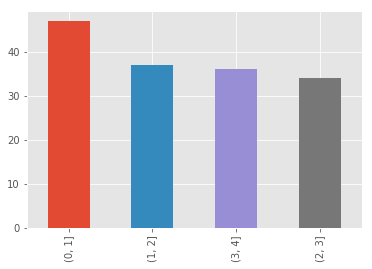

In [7]:
# rain_types.head()
bins_rain_types = pd.cut(data['RAIN'],[0,1,2,3,4])
bins_rain_types = bins_rain_types.cat.as_unordered()

bins_rain_types.value_counts().plot(kind='bar')

In [8]:
data['RAIN']=bins_rain_types
rain_dummies = pd.get_dummies(data['RAIN'], prefix='rain')

In [9]:
new_data = data[['DATE2', 'ENTRIES', 'EXITS', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'is_weekend']]
new_data = pd.concat([new_data,rain_dummies],axis=1)
new_data.rename(columns={'rain_(0, 1]':'rain_1','rain_(1, 2]':'rain_2','rain_(2, 3]':'rain_3','rain_(3, 4]':'rain_4'}, inplace=True)
new_data.head()

,DATE2,ENTRIES,EXITS,PRCP,SNOW,SNWD,TMAX,TMIN,is_weekend,rain_1,rain_2,rain_3,rain_4
0,2017-12-01,30580,26633,0.00,0.0,0.0,52.0,42.0,0,0,0,0,0
1,2017-12-02,11568,10978,0.00,0.0,0.0,48.0,39.0,1,0,0,0,0
2,2017-12-03,7588,7336,0.00,0.0,0.0,48.0,42.0,1,0,0,0,0
3,2017-12-04,32905,27101,0.00,0.0,0.0,51.0,40.0,0,0,0,0,0
4,2017-12-05,32625,27968,0.75,0.0,0.0,61.0,50.0,0,0,0,0,1


In [ ]:
# data['PRCP'].max()
# bins = [.01, 0.08, 0.25, 0.6575, 3]
# categories = ['Mist','Light Rain','Rain', 'Heavy Rain']

# data['PRCP'].hist(bins=bins, set_xlabel = categories)
# data['PRCP'].nunique()
# # feature_plots_with_graphs(wkend_entries)
# data[data['PRCP']>0.01]['PRCP'].quantile(.75)

# data['PRCP'].quantile(0.25)
# data.ENTRIES[data.ENTRIES > 45000]